In [1]:
%matplotlib widget
import numpy as np
import json, glob
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

### Choose the json file:

In [121]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [122]:
TT = TT_PSEN126

quantile_band = 0.8

channel_delay_motor = channel_delay_topas
#channel_delay_motor = channel_delay_harm

timezero_mm = 158.804    ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
#timezero_mm = 40.1268    ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)

#target = 'babyYAG'
#px2fs = 1.8692375 ## calibration from 17.10.2021

########################################
#YAG_scan_one_TT(json_file, TT, channel_delay_motor, timezero_mm, quantile, target, calibration, filterTime=2000, filterAmp=0):
#YAG_scan_one_TT_bs(json_file, TT, channel_delay_motor, timezero_mm, quantile, filterTime=2000, filterAmp=0):
########################################

Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
YAG_scan_one_TT_bs(fc.selected, TT, channel_delay_motor, timezero_mm, quantile_band)

#Delays_corr -= Delay_fs

pp_uncorrected = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

Processing: run0180
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 10 / 10 -> 0% incomplete

-------------------

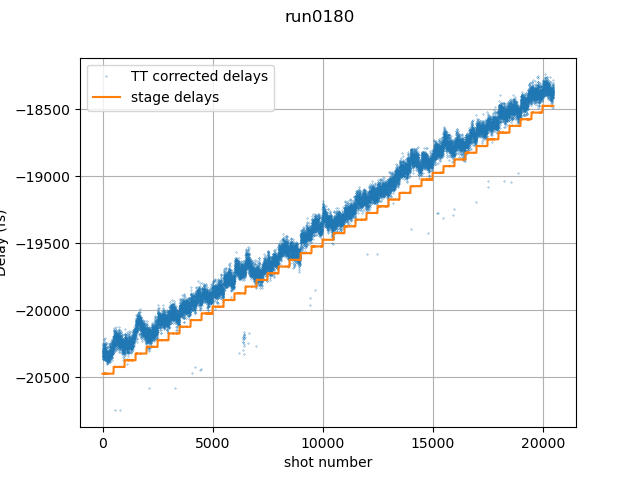

In [123]:
plt.figure()
plt.suptitle(fc.selected.split('/')[-3])
plt.plot(Delays_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

## Re-bin the data with chosen binsize

In [138]:
binsize = 10 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)

(20477,) (20477,)


## Choose fit function

In [139]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [140]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
# print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 
#fit.p0 =[272.1, 0.08, 100, 0.01, 200, 0, 0.05]

fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 155.92394 mm
Width = 164.95482 fs


## Plot

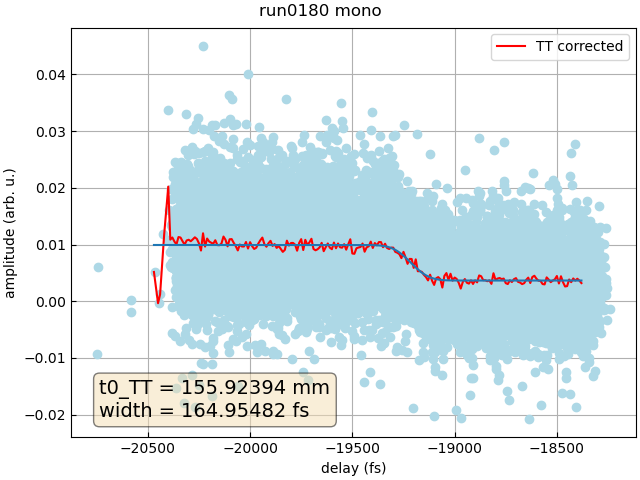

Position t0_raw = 158.804 mm
Position t0_TT = 155.92394473824956 mm


In [141]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3] + " mono")

plt.tick_params(direction='in')

plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(timezero_mm + fs2mm(t0_fs,0),5)),
            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(timezero_mm ))
print("Position t0_TT = {} mm".format(timezero_mm + fs2mm(t0_fs,0)))

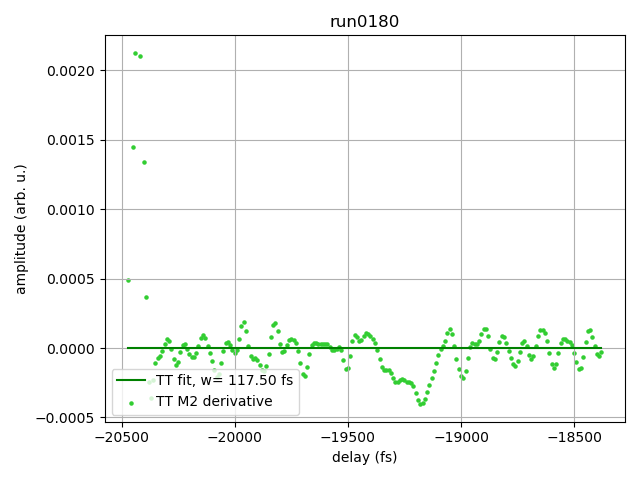

In [129]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])

plt.figure()
plt.title(fc.selected.split('/')[-3])
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.35)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()


In [142]:
7159.224710507621 - 7095.550453730302

63.67425677731899

In [129]:
bounces = np.array([17, 15, 19, 18])


w_17 = np.array([48.31564754, 45.35459989, 46.38803604, 48.82467354, 41.72229399, 51.92472967, 48.20162697, 43.38149879, 49.55902355, 49.24818079])
w_15 = np.array([70.8085, 67.389])
w_19 = np.array([44.02577, 43.35932, 41.31161])
w_18 = np.array([40.225512043089594, 43.83653975522947, 48.13392108999348])

b = np.array([17,17,17,17,17,17,17,17,17,17, 15,15, 19,19,19, 18,18,18])
w_b = np.concatenate((w_17,w_15,w_19,w_18))

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


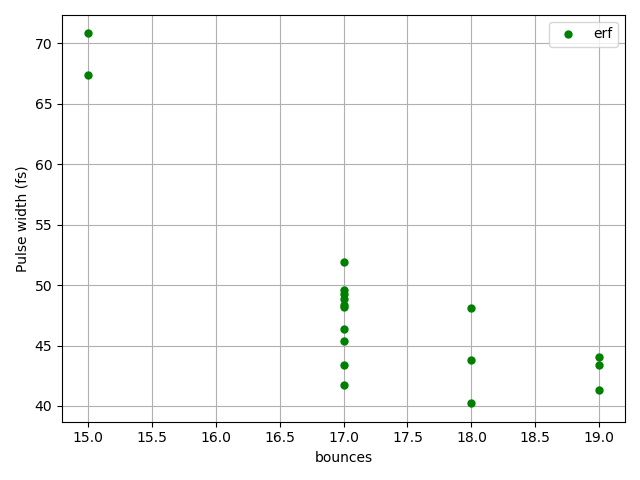

In [133]:
plt.figure()

plt.plot(b, w_b, 'o', ms = 5, color='green', label='erf')
plt.xlabel('bounces')
plt.ylabel('Pulse width (fs)')

plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

In [156]:
wavelengths = np.array([503, 517, 541, 572])

w_503 = np.array([37.13247, 38.08565, 39.697])
w_503_der = np.array([56.568, 56.789, 58.233])

w_517 = np.array([44.83986, 43.528, 40.733])
w_517_der = np.array([65.9581, 65.444, 59.6257])

w_541 = np.array([43.02638, 45.03328, 43.7628])
w_541_der = np.array([64.320231, 66.10226, 62.8714])

w_572 = np.array([45.374, 46.4243 , 49.1044])
w_572_der = np.array([64.1888, 63.1239 , 64.8266 ])

wavelengths = np.array([503,503,503, 517,517,517, 541,541,541, 572,572,572])
w_wl = np.concatenate((w_503, w_517, w_541, w_572))
w_der = np.concatenate((w_503_der, w_517_der, w_541_der, w_572_der))

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


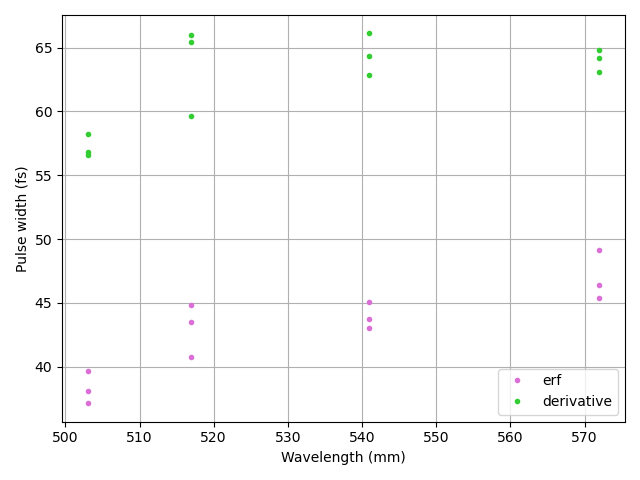

In [157]:
plt.figure()

plt.plot(wavelengths, w_wl, 'o', ms = 3, color='orchid', label='erf')
plt.plot(wavelengths, w_der, 'o', ms = 3, color='limegreen', label='derivative')
plt.xlabel('Wavelength (mm)')
plt.ylabel('Pulse width (fs)')

plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Loop over several runs

In [5]:
datafiles = []
for file in glob('/sf/alvra/data/p19776/raw/catalog/YAG_scan_loop_*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch =  datafiles[2:-1]
patch[13]

'/sf/alvra/data/p19776/raw/catalog/YAG_scan_loop_016.run0048/meta/scan.json'

In [58]:
TT = TT_PSEN126

quantile_band = 0.5
binsize = 10 # in fs

channel_delay_motor = channel_delay_topas

timezero_mm = 40.25550462106695 

target = 'babyYAG'
px2fs = 1.8692375 ## calibration from 17.10.2021

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_scan =[]
width_fs_scan = []

for json_file in patch:
    print (json_file)
    scan = SFScanInfo(json_file)
    
    Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
    YAG_scan_one_TT(json_file, TT, channel_delay_motor, timezero_mm, quantile_band, target, px2fs)

    print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]

    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan.append(width_fs)

Processing: YAG_scan_loop_048.run0080
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile 479 / 501 -> 4% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET           501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET           501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 479 / 501 -> 4% loss
complete channels: 4 / 5 -> 20% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 233 pump and 233 unpump shots
Quantile range = 0.25 0.75
Loaded 61 files, size of the arrays = 61
(14603,) (14603,)


In [59]:
t0_loop1 = t0_fs_scan.copy()
w_loop1 = width_fs_scan.copy()

In [61]:
t0_fs_scan = np.concatenate((t0_loop1, t0_loop2), axis = 0)
width_fs_scan = np.concatenate((w_loop1, w_loop2), axis = 0)

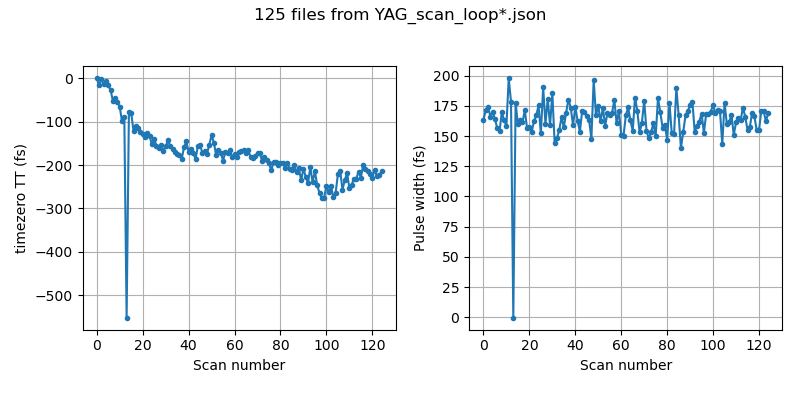

In [65]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle ('{} files from {}'.format(79+46, json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))


plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_scan, marker='.')
plt.xlabel('Scan number')
plt.ylabel('Pulse width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
channel_pressure = "SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS"
channel_list = [channel_pressure]

from sfdata import SFScanInfo
pressure_scan = []
for json_file in patch:
    scan = SFScanInfo(json_file)
    pressure_run = []
    for i, step in enumerate(scan):
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print (json_file)
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
        results,_ = load_data_compact(channel_list, step)
        pressure = results[channel_pressure].mean()
        pressure_run.append(pressure)
    pressure_scan.append(np.mean(pressure_run))

##  Timing tool traces & statistics

In [2]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
TT = TT_PSEN126

target = 'babyYAG'
px2fs = 1.8692375 

arrTimes, arrTimesAmp, arrTimes_scan, arrTimesAmp_scan, peaktraces = \
TT_statistics_scan(fc.selected, TT, target, px2fs)

Processing: run0154
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)


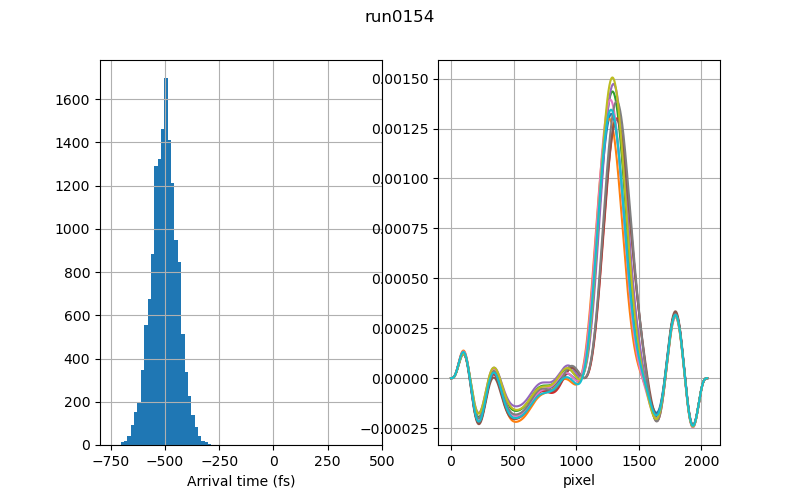

Statistics on all (14543,) shots of the scan
Offset compared to pixel 1024 is -502.3513764672008 fs
Jitter, i.e. width (std) of the histogram 59.857580568151434 fs
--------------------------------------------------------------
Statistics on (250,) shots of the last step of the scan
Offset compared to pixel 1024 is -504.67169415 fs
Jitter, i.e. width (std) of the histogram 44.93531310824471 fs


In [7]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(arrTimes_scan, bins=30)
plt.grid()
plt.xlim(-800,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(122)
plt.suptitle (fc.selected.split('/')[-3])
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()
plt.show()

print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_scan)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes)))
